In [1]:
import numpy as np
import pandas as pd
import os
import torch
from utils.csv_to_pd import *
from utils.lstm_tool import *

In [2]:
df = read_dir_csv()

location_ori = list(df["LocationCode"]) 
df = mean_10min(df)
origin_df = df.copy()
df.mean()

DateTime           2024-05-11 06:45:56.741521408
LocationCode                            9.143635
WindSpeed(m/s)                          0.307696
Pressure(hpa)                        1009.117356
Temperature(°C)                        30.547611
Humidity(%)                            70.424098
Sunlight(Lux)                       21193.740139
Power(mW)                             245.880951
dtype: object

In [3]:
df['hour'] = df['DateTime'].dt.hour
df['month'] = df['DateTime'].dt.month
df['Pressure(hpa)'] -= df['Pressure(hpa)'].mean()
df['Temperature(°C)'] -= df['Temperature(°C)'].mean()
df['Humidity(%)'] -= df['Humidity(%)'].mean()
df['Sunlight(Lux)'] -= df['Sunlight(Lux)'].mean()
df['Power(mW)'] -= df['Power(mW)'].mean()
df[:1]

,DateTime,LocationCode,WindSpeed(m/s),Pressure(hpa),Temperature(°C),Humidity(%),Sunlight(Lux),Power(mW),hour,month
0,2024-03-01 17:10:00,10.0,0.124286,8.372644,-14.834754,23.34733,-20540.942996,-245.765237,17,3


In [4]:
from sklearn.preprocessing import MinMaxScaler


columns_to_normalize = ['WindSpeed(m/s)', 'Pressure(hpa)', 'Temperature(°C)', 'Humidity(%)', 'Sunlight(Lux)', 'Power(mW)']
scaler = MinMaxScaler()
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

df[['LocationCode']] /= 17 
df[['hour']] /= 24
df[['month']] /= 12
df = df[['LocationCode', 'hour', 'month', 'WindSpeed(m/s)', 'Pressure(hpa)', 'Temperature(°C)', 'Humidity(%)', 'Sunlight(Lux)', 'DateTime', 'Power(mW)']]
df[:1]

,LocationCode,hour,month,WindSpeed(m/s),Pressure(hpa),Temperature(°C),Humidity(%),Sunlight(Lux),DateTime,Power(mW)
0,0.588235,0.708333,0.25,0.012153,0.028831,0.122648,0.582997,0.005375,2024-03-01 17:10:00,0.000051


In [5]:
def weather_data_spilt_with_datetime(df: pd.DataFrame, location_ori):
    datetime_list = list(df['DateTime'])
    

    data_df = df.drop(columns=['DateTime'])
    label_df = df.drop(columns=['DateTime', 'LocationCode', 'hour', 'month'])

    data_label_list = []
    last_index = 0

    start_time = []

    for i in range(1, len(datetime_list) - 1):
        date = datetime_list[i]
        last_date = datetime_list[i - 1]
        if date.day != last_date.day or \
            date.hour * 60 + date.minute - 10 != last_date.hour * 60 + last_date.minute or \
                location_ori[i] != location_ori[i - 1]:
            
            start_time.append(datetime_list[last_index].hour)
            if (last_index != i - 1):
                data = torch.from_numpy(np.array(data_df.iloc[last_index: i - 1]))
                label = torch.from_numpy(np.array(label_df.iloc[last_index + 1: i]))

                data_label_list.append((len(data), data, label))
            last_index = i
    
    return data_label_list, start_time

data_label_list, _ = weather_data_spilt_with_datetime(df, location_ori)
print(data_label_list[0][1].shape, data_label_list[0][2].shape)

torch.Size([5, 9]) torch.Size([5, 6])


In [6]:


train_data_label_list, valid_data_label_list = split_data_random(data_label_list)

train_data, train_label, train_length = sort_by_length(train_data_label_list)
valid_data, valid_label, valid_length = sort_by_length(valid_data_label_list)

print(train_data_label_list[0][0], train_data_label_list[0][1].shape, train_data_label_list[0][2].shape)
print(train_length[0], train_data[0].shape, train_label[0].shape)

83 torch.Size([83, 9]) torch.Size([83, 6])
1 torch.Size([1, 9]) torch.Size([1, 6])


In [7]:

batch_train_data, batch_train_label, batch_train_length = padding(train_data, train_label, train_length)
batch_valid_data, batch_valid_label, batch_valid_length = padding(valid_data, valid_label, valid_length)

batch_train_data[-1].shape

train_loader = list(zip(batch_train_data, batch_train_label, batch_train_length))
valid_loader = list(zip(batch_valid_data, batch_valid_label, batch_valid_length))



In [8]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from torch import nn

In [9]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class LSTMTagger(nn.Module):

    def __init__(self, hidden_dim, tagset_size=5, input_dim=8):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        # LSTM層
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)

        # 線性層
        self.linear = nn.Linear(hidden_dim, tagset_size)
        self.relu = nn.ReLU()

    def init_hidden(self, batch_size):
        # 初始化隱藏狀態和細胞狀態
        return (torch.zeros(1, batch_size, self.hidden_dim),
                torch.zeros(1, batch_size, self.hidden_dim))

    def forward(self, sentence, hidden, lengths):
        """
        sentence: Tensor, shape (batch_size, seq_len, input_dim)
        lengths: List of sequence lengths (before padding)
        hidden: Initial hidden state

        Returns:
            tag_space: Tensor, shape (batch_size, seq_len, tagset_size)
            hidden: Final hidden state
        """
        # 動態打包序列
        packed_input = pack_padded_sequence(sentence, lengths, batch_first=True, enforce_sorted=False)

        # LSTM層
        packed_output, hidden = self.lstm(packed_input, hidden)

        # 解包序列
        lstm_out, _ = pad_packed_sequence(packed_output, batch_first=True)
        # lstm_out, hidden = self.lstm(sentence, hidden)
        # 線性層和激活函數


        tag_space = self.relu(self.linear(self.relu(lstm_out)))

        return tag_space, hidden


In [10]:
import torch
import torch.optim as optim
import torch.nn as nn

# 設置 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定義訓練函數
def train_model(model, train_loader, valid_loader, train_length, valid_length, num_epochs=10, learning_rate=0.001):
    # 將模型移到 GPU
    model = model.to(device, dtype=torch.float32)
    # 使用 Adam 優化器
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # 定義損失函數
    criterion = nn.SmoothL1Loss()
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        real_length = 0
        for inputs, labels, length in train_loader:
            # 將輸入和標籤移到 GPU
            inputs, labels, length = inputs.to(device, dtype=torch.float32), labels.to(device, dtype=torch.float32), length.to('cpu', dtype=torch.int64)
            
            # 初始化隱藏狀態
            hidden = model.init_hidden(batch_size=inputs.size(0))
            hidden = tuple([h.to(device, dtype=torch.float32) for h in hidden])


            # 清零梯度
            optimizer.zero_grad()
            # 前向傳播
            outputs, _ = model(inputs, hidden, length)
            # 計算損失
            loss = criterion(outputs.squeeze(), labels)
            # 反向傳播
            loss.backward()
            # 更新參數
            optimizer.step()

            total_loss += loss.item() * len(outputs)
            real_length += length.sum().item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {total_loss / real_length:.4f}")

        # 驗證模型
        validate_model(model, valid_loader, criterion, valid_length)

# 定義驗證函數
def validate_model(model, valid_loader, criterion, valid_length):
    model.eval()
    total_loss = 0.0
    real_length = 0
    with torch.no_grad():
        for inputs, labels, length in valid_loader:
            # 將輸入和標籤移到 GPU
            inputs, labels, length = inputs.to(device, dtype=torch.float32), labels.to(device, dtype=torch.float32), length.to('cpu', dtype=torch.int64)
            
            # 初始化隱藏狀態
            hidden = model.init_hidden(batch_size=inputs.size(0))
            hidden = tuple([h.to(device, dtype=torch.float32) for h in hidden])

            # 前向傳播
            outputs, _ = model(inputs, hidden, length)
            # 計算損失
            loss = criterion(outputs.squeeze(), labels.squeeze())
            total_loss += loss.item() * len(outputs)
            real_length += length.sum().item()

    print(f"Validation Loss: {total_loss / real_length:.4f}")
    return total_loss


In [11]:
model = LSTMTagger(256, tagset_size=6, input_dim=9)
train_length, valid_length = len(batch_train_data), len(batch_valid_data)
train_model(model, train_loader, valid_loader, train_length, valid_length, 50)


Epoch [1/50], Training Loss: 0.0004
Validation Loss: 0.0002
Epoch [2/50], Training Loss: 0.0001
Validation Loss: 0.0001
Epoch [3/50], Training Loss: 0.0001
Validation Loss: 0.0001
Epoch [4/50], Training Loss: 0.0001
Validation Loss: 0.0000
Epoch [5/50], Training Loss: 0.0001
Validation Loss: 0.0000
Epoch [6/50], Training Loss: 0.0000
Validation Loss: 0.0000
Epoch [7/50], Training Loss: 0.0000
Validation Loss: 0.0000
Epoch [8/50], Training Loss: 0.0000
Validation Loss: 0.0000
Epoch [9/50], Training Loss: 0.0000
Validation Loss: 0.0000
Epoch [10/50], Training Loss: 0.0000
Validation Loss: 0.0000
Epoch [11/50], Training Loss: 0.0000
Validation Loss: 0.0000
Epoch [12/50], Training Loss: 0.0000
Validation Loss: 0.0000
Epoch [13/50], Training Loss: 0.0000
Validation Loss: 0.0000
Epoch [14/50], Training Loss: 0.0000
Validation Loss: 0.0000
Epoch [15/50], Training Loss: 0.0000
Validation Loss: 0.0000
Epoch [16/50], Training Loss: 0.0000
Validation Loss: 0.0000
Epoch [17/50], Training Loss: 0.0

In [12]:
print(valid_loader[-1][0].shape)

torch.Size([54, 84, 9])


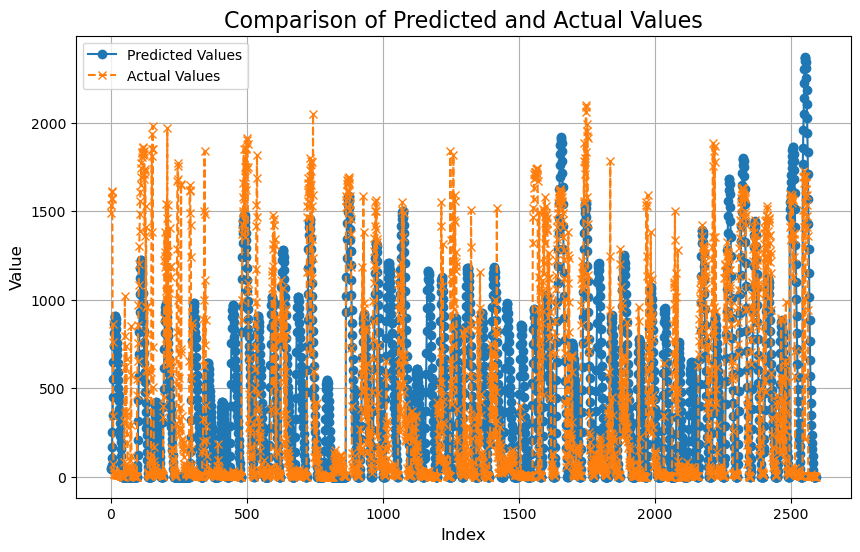

356.38365819861934


In [23]:

model.eval()
error = 0
data_num = 0
model = model.to('cpu', dtype=torch.float32)

power_min = origin_df['Power(mW)'].min()
power_max = origin_df['Power(mW)'].max()
power_mean = origin_df['Power(mW)'].mean()

error_list = []

n = len(valid_loader[-1][0])
predict_list = []
label_list = []
for index in range(n):

    
    with torch.no_grad():
        split_pos = 0

        while valid_loader[-1][0][index][split_pos][1] < 9 / 24:
            split_pos += 1

        if split_pos == 0:
            continue



        inputs, labels, lengths = valid_loader[-1][0][index][:split_pos].unsqueeze(dim=0), valid_loader[-1][1][index][split_pos:], torch.tensor([12])
        inputs, lengths = inputs.to('cpu', dtype=torch.float32), lengths.to('cpu', dtype=torch.int64)
        
        hidden = model.init_hidden(batch_size=inputs.size(0))
        hidden = tuple([h.to('cpu', dtype=torch.float32) for h in hidden])
        outputs, hidden = model(inputs, hidden, lengths)
        
        
        support_datas = valid_loader[-1][0][index][split_pos:][:, :3].numpy()
        count = 0
        for support_data, label in zip(support_datas, labels):
            if support_data[0] == 0 or count == 48:
                break
            count += 1

            support_data = list(support_data)
            outputs = list(outputs[0, -1].numpy())
            support_data.extend(outputs)

            inputs_tensor = torch.from_numpy(np.array(support_data)).unsqueeze(dim=0).unsqueeze(dim=0).to('cpu', dtype=torch.float32)
            
            outputs, hidden = model(inputs_tensor, hidden, torch.tensor([1]))
            predict_power = outputs[0, 0, -1].item() * (power_max - power_min) + power_min
            label_power = label[-1].item() * (power_max - power_min) + power_min

            #print(outputs, label)

            predict_list.append(predict_power)
            label_list.append(label_power)

            error_list.append(abs(predict_power - label_power))
    
# 創建折線圖
plt.figure(figsize=(10, 6))
plt.plot(range(len(predict_list)), predict_list, label="Predicted Values", linestyle='-', marker='o')
plt.plot(range(len(label_list)), label_list, label="Actual Values", linestyle='--', marker='x')

# 圖表標題和標籤
plt.title("Comparison of Predicted and Actual Values", fontsize=16)
plt.xlabel("Index", fontsize=12)
plt.ylabel("Value", fontsize=12)

# 顯示圖例
plt.legend()

# 顯示圖表
plt.grid(True)  # 加網格線以便觀察數據
plt.show()

error_list = np.array(error_list)
print(error_list.mean())